# Code for reproducing results in Figure 7

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.gridspec as gridspec

import os
from tqdm import tqdm
from loren_frank_data_processing import make_epochs_dataframe, make_neuron_dataframe
from src.parameters import ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS

from scipy.signal import hilbert

from utils import bandpassfilter

### get the phase of each spike

In [3]:
def get_phase(filtered_lfp):

    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi

    return instantaneous_phase


def get_phase_from_all_channels(epoch_key, DATA_DIR, lowcut=25, highcut=50):

    animal, day, epoch = epoch_key
    # load lfp
    lfp_filename = os.path.join(
        DATA_DIR,
        "ThetaSweepTrajectories",
        f"{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl",
    )
    with open(lfp_filename, "rb") as f:
        lfp_info = pickle.load(f)

    phase = pd.DataFrame(index=lfp_info.index)
    for i in range(len(lfp_info.columns)):
        lfp = bandpassfilter(
            lfp_info.iloc[:, i], lowcut=lowcut, highcut=highcut, fs=500
        )
        lfp = pd.DataFrame(lfp, index=lfp_info.index)
        # zscore the lfp
        lfp = (lfp - lfp.mean()) / lfp.std()
        # store them with the same column name as the lfp_info
        phase[lfp_info.columns[i]] = get_phase(lfp)
    return phase, lfp


def get_stepsize_multiunitspikes_phase(
    epoch_key,
    DATA_DIR,
    unitlength=10,
    step_interval=3,
    distance_threshold=40,
    traj_length_threshold=0,
    lowcut=25,
    highcut=50,
):

    """
    This function calculates the step size, multiunit spikes, multiunit firing rate, and phase for each awake replay epoch
    Input:
        epoch_key: a tuple of (animal, day, epoch)
        DATA_DIR: the directory of the data
        unitlength: the length of each time bin
        step_interval: the interval between two successive time bins
        distance_threshold: the threshold of the start-to-end distance of a replay trajectory
        traj_length_threshold: the threshold of the number of steps of a replay trajectory
        lowcut: the lowcut frequency of the bandpass filter
        highcut: the highcut frequency of the bandpass filter

    """

    animal, day, epoch = epoch_key

    # get multiunit spikes under folder: ThetaSweepTrajectories
    # load multiunit firing rate
    multiunit_fr_filename = os.path.join(
        DATA_DIR,
        "ThetaSweepTrajectories",
        f"{animal}_{day:02d}_{epoch:02d}_spike_info.pkl",
    )
    with open(multiunit_fr_filename, "rb") as f:
        [spike, multiunit, multiunit_fr] = pickle.load(f)

    multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)).astype(np.float)

    # get phase foor all lfp channels
    phase, _ = get_phase_from_all_channels(
        epoch_key, DATA_DIR, lowcut=lowcut, highcut=highcut
    )
    phase = phase.reindex(spike.index, fill_value=0)

    # get ripple time from csv file under folder: ReplayTrajectories
    replay_info_path = os.path.join(
        DATA_DIR,
        "ReplayTrajectories/"
        f"{animal}_{day:02d}_{epoch:02d}_clusterless_1D_no_interneuron_replay_info_80.csv",
    )

    # read the csv file and extract the first three columns
    replay_info = pd.read_csv(replay_info_path, usecols=[0, 1, 2])

    # get the replay trajectory from pkl file under folder: ReplayTrajectories
    with open(
        os.path.join(
            DATA_DIR, "ReplayTrajectories", f"{animal}_{day:02d}_{epoch:02d}_traj.pkl"
        ),
        "rb",
    ) as f:
        Replay_traj = pickle.load(f)

    # for each replay trajectory in Replay_traj, calculate te step size of two successive points
    # and get the multiunit spikes in the corresponding time bin
    step_size = []
    multiunit_spikes_at_step_size = []
    multiunit_fr_at_step_size = []
    phase_at_step_size = []
    times = spike.index
    sum_multiunit_spikes = np.sum(multiunit_spikes, axis=1)

    for i in Replay_traj.keys():
        # get the start time of the replay trajectory
        replay_start_time = replay_info.loc[
            replay_info["ripple_number"] == i, "start_time"
        ].values[0]
        # keep strings after 'days '
        replay_start_time = replay_start_time.split("days ")[1]
        # convert to time delta
        replay_start_time = pd.to_timedelta(replay_start_time)

        traj = Replay_traj[i]

        # if event is less than 10 steos or the start-to-end distacne is less than 80 cm, then skip
        if len(traj) < traj_length_threshold:
            continue
        # filterout the replay trajectory with start-to-end distance that is less than 40 cm
        if np.abs(traj[-1] - traj[0]) < distance_threshold:
            continue

        # each bin is unitlength, next bin is advanced by stepsize
        for j in range(0, len(traj) - unitlength - step_interval, step_interval):
            ave_traj_in_previous_bin = np.mean(traj[j : j + unitlength])
            ave_traj_in_next_bin = np.mean(
                traj[j + step_interval : j + step_interval + unitlength]
            )
            step_size.append(np.abs(ave_traj_in_next_bin - ave_traj_in_previous_bin))

            # get the time bin of the point by adding j*0.002 s to replay_start_time: 0.002 is the decoding time window
            timej_start = replay_start_time + pd.to_timedelta(j * 0.002, unit="s")
            timej_end = replay_start_time + pd.to_timedelta(
                (j + step_interval + unitlength) * 0.002, unit="s"
            )

            # get all the index from timej_start to timej_end in times
            index = times.get_indexer_for(
                times[(times >= timej_start) & (times <= timej_end)]
            )
            # print(index)
            # get the multiunit spikes in the corresponding time bin using the index
            summed_spikes = np.sum(sum_multiunit_spikes[index])

            multiunit_spikes_at_step_size.append(summed_spikes)
            # get the multiunit firing rate in the corresponding time bin using the index
            multiunit_fr_at_step_size.append(
                np.mean(multiunit_fr.iloc[index]).values[0]
            )

            # get the phase in the corresponding time bin using the index
            phase_subset = phase.iloc[index]
            multiunit_spikes_ind = multiunit_spikes[index]
            # turn phase_at_step_size into a vector
            phase_subset_vec = phase_subset.values.reshape(-1)
            # turn multiunit_spikes_ind into a vector
            multiunit_spikes_vec = multiunit_spikes_ind.reshape(-1)
            phase_subset_vec = np.array(phase_subset_vec)
            multiunit_spikes_vec = np.array(multiunit_spikes_vec)
            # select the phase only when multiunit_spikes_vec is 1 ()only whne there is spike event)
            phase_selected = phase_subset_vec[multiunit_spikes_vec == 1]
            # calculate the circular mean of phase_selected which is a vector
            mean_phase = np.angle(np.mean(np.exp(1j * phase_selected)))
            # get the average phase when multiunit_spikes_vec is 1
            phase_at_step_size.append(mean_phase)

        # replay_end_time = replay_info.loc[replay_info['ripple_number'] == i, 'end_time'].values[0]
        # print timej_end, replay_end_time, and the difference between them
        # print(timej_end, replay_end_time, replay_end_time-timej_end)

    return [
        np.array(step_size),
        np.array(multiunit_spikes_at_step_size),
        np.array(multiunit_fr_at_step_size),
        np.array(phase_at_step_size),
    ]

### get the stepsize, multiunit spikes, and phase information for each replay trajectory for all animals

In [4]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
    (neuron_info.type == "principal")
    & (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
]

n_neurons = (
    neuron_info.groupby(["animal", "day", "epoch"])
    .neuron_id.agg(len)
    .rename("n_neurons")
    .to_frame()
)

epoch_info = epoch_info.join(n_neurons)
is_w_track = epoch_info.environment.isin(["TrackA", "TrackB", "WTrackA", "WTrackB"])
is_animal = epoch_info.index.isin(
    ["bon", "fra", "gov", "dud", "con", "Cor", "dav", "egy", "cha"], level="animal"
)

valid_epochs = is_w_track & (epoch_info.n_neurons > MIN_N_NEURONS) & is_animal

#%%
DATA_DIR = "/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis"
# initialize the dictionary to store the step size, multiunit spikes and multiunit firing rate for each epoch
all_step_size = {}
all_multiunit_spikes_at_step_size = {}
all_multiunit_fr_at_step_size = {}
all_phase_at_step_size = {}

unitlength = 10
step_interval = 3
lowcut = 25
highcut = 50
distance_threshold = 40

# check if the pickle file already exists
# if yes, then load the pickle file
# if no, then calculate the step size, multiunit spikes and multiunit firing rate for each epoch
savefolder = os.path.join(DATA_DIR, "anti_phase_corrrelation_results")
filename = os.path.join(
    savefolder,
    f"zscore_anti_phase_corrrelation_results_unitlength{unitlength}_step_interval{step_interval}_lowcut{lowcut}_highcut{highcut}_distance_threshold{distance_threshold}.pkl",
)

if os.path.exists(filename):
    with open(filename, "rb") as f:
        [
            all_step_size,
            all_multiunit_spikes_at_step_size,
            all_multiunit_fr_at_step_size,
            all_phase_at_step_size,
        ] = pickle.load(f)

else:
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
        animal, day, epoch = epoch_key

        # print(epoch_key)

        # step_size, multiunit_spikes_at_step_size, multiunit_fr_at_step_size, phase_at_step_size = get_stepsize_multiunitspikes_phase(epoch_key, DATA_DIR, step_interval=10)

        results = get_stepsize_multiunitspikes_phase(
            epoch_key,
            DATA_DIR,
            unitlength=unitlength,
            step_interval=step_interval,
            distance_threshold=40,
            traj_length_threshold=0,
            lowcut=lowcut,
            highcut=highcut,
        )

        (
            step_size,
            multiunit_spikes_at_step_size,
            multiunit_fr_at_step_size,
            phase_at_step_size,
        ) = results

        # save the step size, multiunit spikes and multiunit firing rate for each epoch
        all_step_size[epoch_key] = step_size
        all_multiunit_spikes_at_step_size[epoch_key] = multiunit_spikes_at_step_size
        all_multiunit_fr_at_step_size[epoch_key] = multiunit_fr_at_step_size
        all_phase_at_step_size[epoch_key] = phase_at_step_size

    with open(filename, "wb") as f:
        pickle.dump(
            [
                all_step_size,
                all_multiunit_spikes_at_step_size,
                all_multiunit_fr_at_step_size,
                all_phase_at_step_size,
            ],
            f,
        )

### check the anti-phase correlation between step size and spikes at gamma phase: merge cross all animals

epochs: 100%|██████████| 140/140 [00:00<00:00, 25915.90it/s]


epochs: 100%|██████████| 140/140 [00:00<00:00, 21615.35it/s]


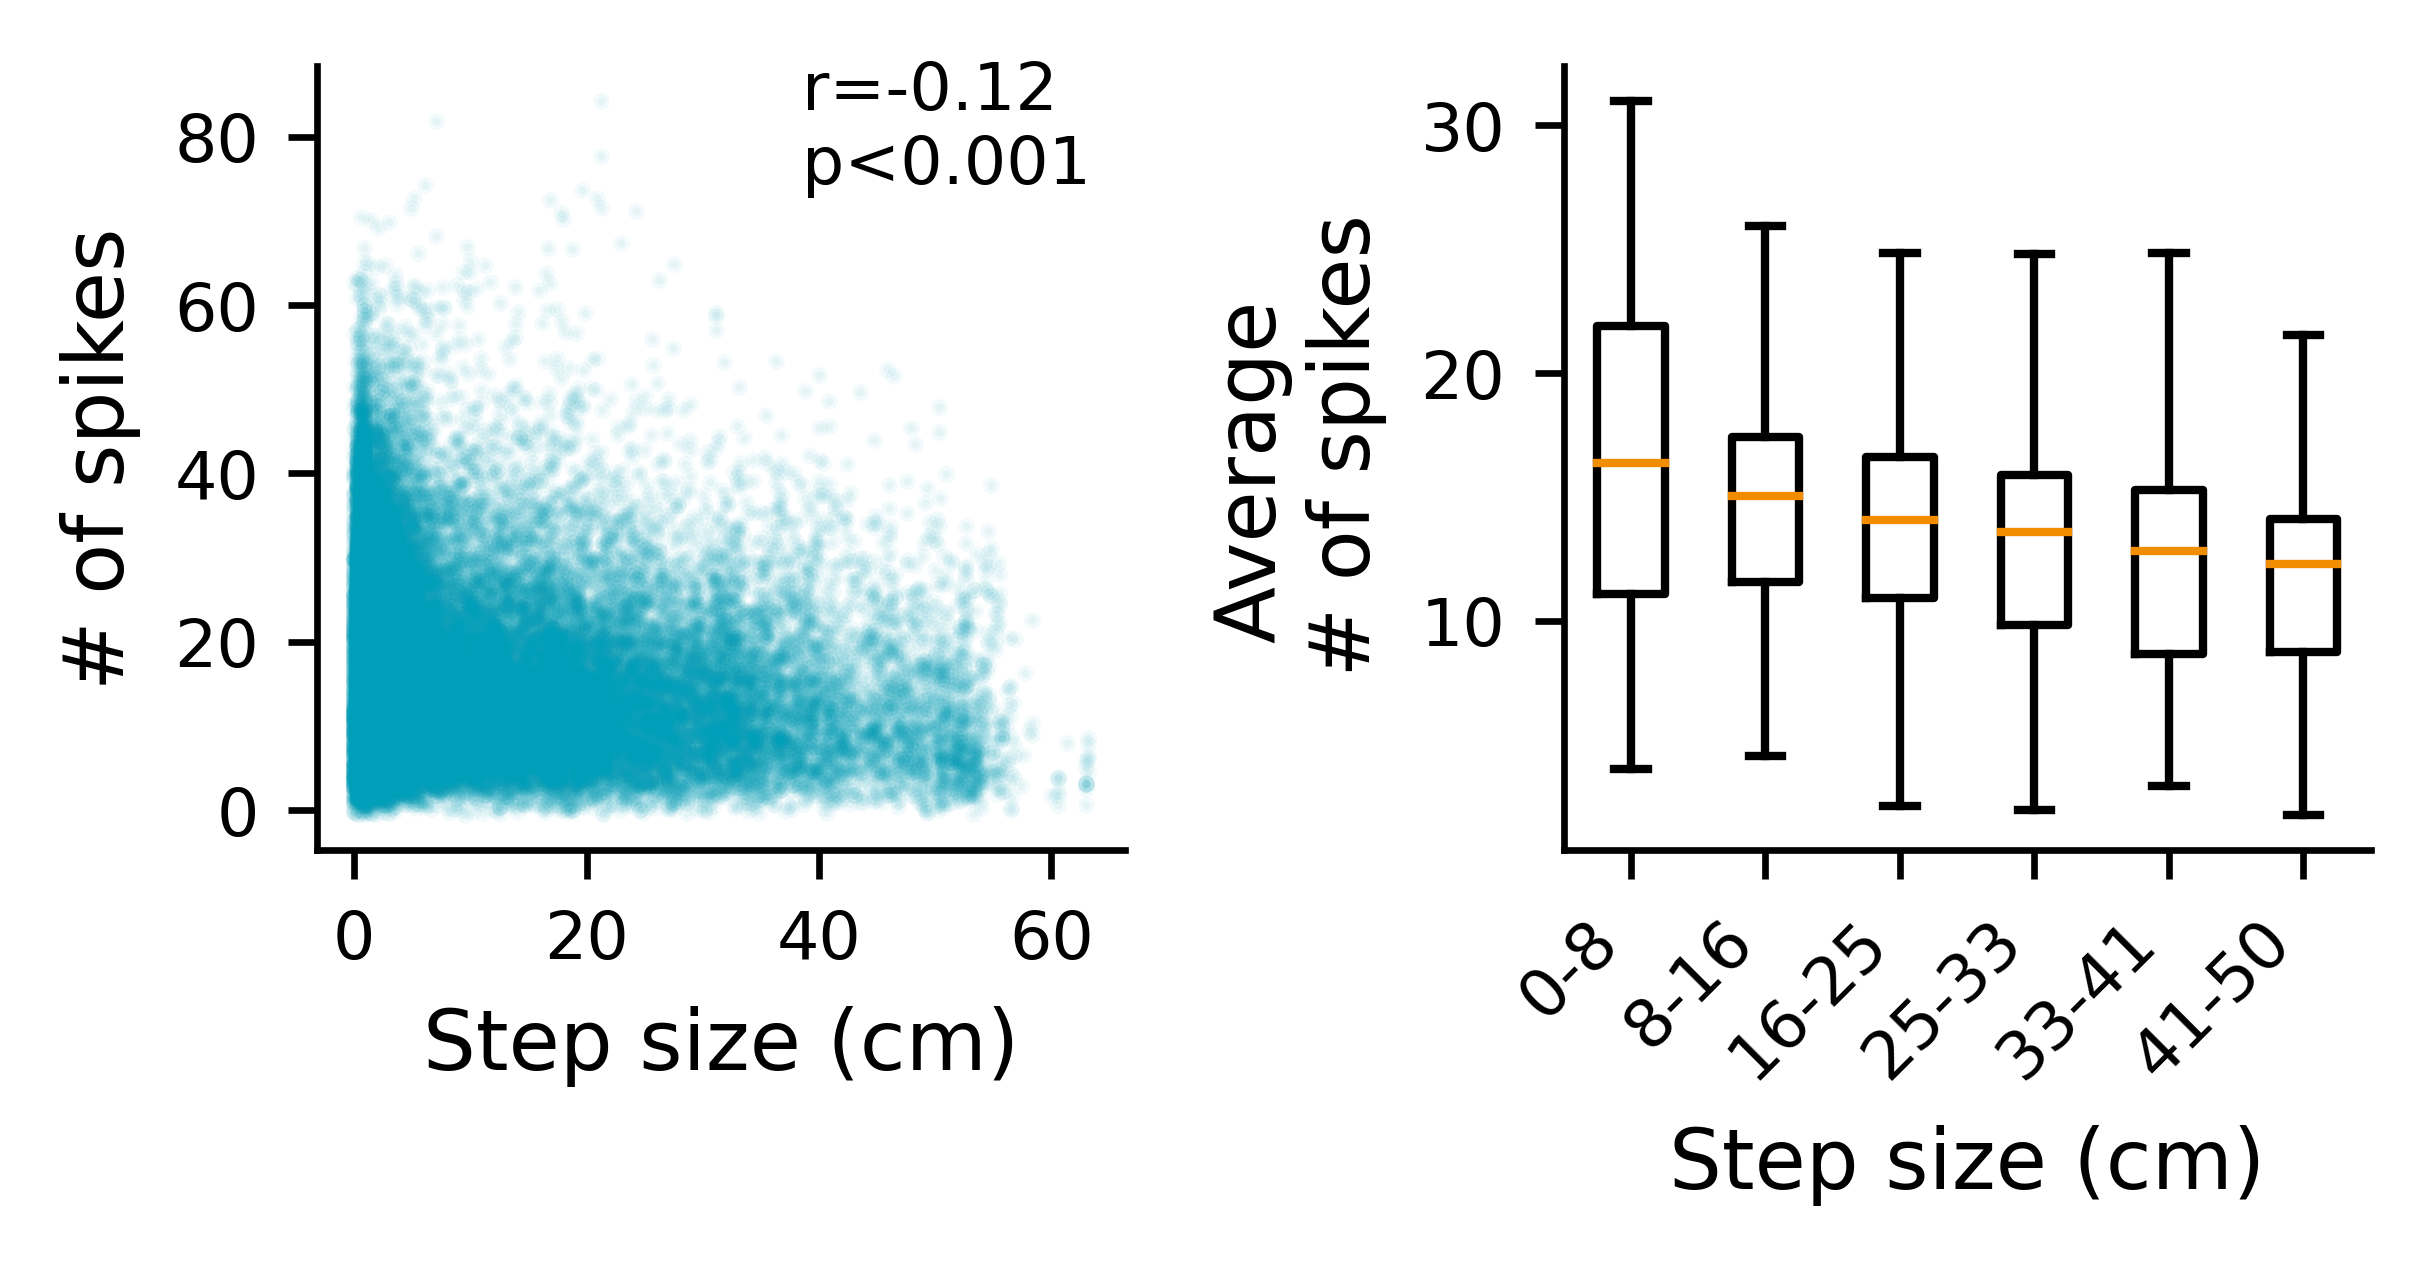

In [6]:
# merge values in all_step_size and all_multiunit_spikes_at_step_size into a list and plot step_size vs multiunit_spikes_at_step_size as scatter plot
all_step_size_list = []
all_multiunit_spikes_at_step_size_list = []
all_phase_at_step_size_list = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
    animal, day, epoch = epoch_key
    all_step_size_list.extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_list.extend(
        all_multiunit_spikes_at_step_size[epoch_key]
    )
    all_phase_at_step_size_list.extend(all_phase_at_step_size[epoch_key])

# remove points with all_step_size_list<1 for better visualization
all_step_size_list = np.array(all_step_size_list)
all_multiunit_spikes_at_step_size_list = np.array(
    all_multiunit_spikes_at_step_size_list
)
all_phase_at_step_size_list = np.array(all_phase_at_step_size_list)

thres = 0
all_step_size_array = all_step_size_list[all_step_size_list > thres]
all_multiunit_spikes_at_step_size_array = all_multiunit_spikes_at_step_size_list[
    all_step_size_list > thres
]
all_phase_at_step_size_array = all_phase_at_step_size_list[all_step_size_list > thres]

fig = plt.figure(figsize=(4.15, 2.2), dpi=300)
gs = gridspec.GridSpec(1, 2)

labelsize = 10
ticksize = 8

# scatter plot
ax4 = plt.subplot(gs[0])

ax4.scatter(
    all_step_size_array,
    all_multiunit_spikes_at_step_size_array
    + np.random.uniform(-0.5, 0.5, len(all_multiunit_spikes_at_step_size_array)),
    s=1,
    c="#009FB9",
    alpha=0.05,
)

# check the person correlation between step size and multiunit spikes and add p abd r values to the plot, with p values as scientific notation
from scipy.stats import pearsonr

r, p = pearsonr(all_step_size_array, all_multiunit_spikes_at_step_size_array)
if p < 0.001:
    ax4.text(
        0.6,
        0.85,
        f"r={r:.2f}\np<0.001",
        transform=plt.gca().transAxes,
        fontsize=ticksize,
    )
else:
    ax4.text(
        0.6,
        0.85,
        f"r={r:.2f}\np={p:.3f}",
        transform=plt.gca().transAxes,
        fontsize=ticksize,
    )

ax4.set_xlabel("Step size (cm)", fontsize=labelsize)
ax4.set_ylabel("# of spikes", fontsize=labelsize)

############################################################################################################

# merge the step size, multiunit spikes and multiunit firing rate from epochs under each animal each day into a list
all_step_size_perday = {}
all_multiunit_spikes_at_step_size_perday = {}
all_multiunit_fr_at_step_size_perday = {}
all_phase_at_step_size_perday = {}

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
    animal, day, epoch = epoch_key
    all_step_size_perday.setdefault((animal, day), []).extend(all_step_size[epoch_key])
    all_multiunit_spikes_at_step_size_perday.setdefault((animal, day), []).extend(
        all_multiunit_spikes_at_step_size[epoch_key]
    )
    all_multiunit_fr_at_step_size_perday.setdefault((animal, day), []).extend(
        all_multiunit_fr_at_step_size[epoch_key]
    )
    all_phase_at_step_size_perday.setdefault((animal, day), []).extend(
        all_phase_at_step_size[epoch_key]
    )

ax5 = plt.subplot(gs[1])

all_bined_multiunitspikeS = {}
for animal_day in all_step_size_perday.keys():
    stepsizeS = np.array(all_step_size_perday[animal_day])
    multiunitspikeS = np.array(all_multiunit_spikes_at_step_size_perday[animal_day])
    # split stepsizeS into 10 bins, in each bin, count the number of multiunit spikes

    bins = np.linspace(0, 50, 7)
    # get the index of the bin that each stepsizeS belongs to
    inds = np.digitize(stepsizeS, bins)
    # get the number of multiunit spikes in each bin
    multiunitspikeS_binned = [
        np.nanmean(multiunitspikeS[inds == i]) for i in range(1, len(bins))
    ]

    all_bined_multiunitspikeS[animal_day] = multiunitspikeS_binned[0:]

# convert the dictionary to numpy array
all_bined_multiunitspikeS_array = np.array(list(all_bined_multiunitspikeS.values()))

# replace nan value with the nanmean in that column
for column_i in range(all_bined_multiunitspikeS_array.shape[1]):
    nan_index = np.isnan(all_bined_multiunitspikeS_array[:, column_i])
    all_bined_multiunitspikeS_array[nan_index, column_i] = np.nanmean(
        all_bined_multiunitspikeS_array[:, column_i]
    )

# plot box plot with mean and std, change the color of mean to red, remove the median line
ax5.boxplot(
    all_bined_multiunitspikeS_array,
    showmeans=True,
    meanline=True,
    showfliers=False,
    flierprops=dict(markersize=3),
    meanprops=dict(color="#F18D00", linestyle="-", linewidth=1),
    medianprops=dict(color="#009FB9", alpha=0),
)

# set the xlabels for each bin using values in bins
ax5.set_xticklabels(
    [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(0, len(bins) - 1)],
    rotation=45,
    ha="right",
)

ax5.set_xlabel("Step size (cm)", fontsize=labelsize)
ax5.set_ylabel("Average \n # of spikes", fontsize=labelsize)
# yticks in scientific notation
# ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0),useMathText=True)

# for all axes, set tick size as ticksize, set x and y tick label size as labelsize
# remove top and right spines
for ax in [ax4, ax5]:
    ax.tick_params(axis="both", which="major", labelsize=ticksize)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# add a sup title
# add a super title
# fig.suptitle('Experimental data', fontsize=labelsize)

plt.tight_layout()
# save figure with background as white
plt.savefig(
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/Fig7_anticorrelation_between_stepsize_neuralactivity_experimentaldata.pdf",
    dpi=300,
    facecolor="white",
)